In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

def plot_df(df, ds_name, l=125, k=20):
    df = df.sort_values(['length', 'backend'], ascending=[True, True]).reset_index()  #drop=True    
    df_normed = df.reset_index().groupby(["length"]).apply(lambda l: l["extent"] * 100 / (l["extent"].iloc[-1])).reset_index()
    # df_normed.set_index("length").head()
    df["extent_normed"] = df_normed["extent"]
        
    df["memory in MB"] = df["memory in MB"] / 1024
    df.set_index("length", inplace=True, drop=True)
    df = df.sort_values(by="backend") 

    # df.index = df.index*2
    
    mask = df.backend=="default"
    subset = df[mask] 
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    sns.lineplot(x=df.index, hue=df.backend, y=df["time in s"], ax=axes[0])
    axes[0].set_title("Time in s", fontsize=18)
    axes[0].tick_params(axis='x', labelrotation=-25)
    axes[0].set_xlabel("Length n")
    # axes[0].set_yscale('log')
    plt.yticks(fontsize=10)
    plt.ylabel("Time in s")
    sns.despine()
    
    sns.lineplot(x=df.index, hue=df.backend, y=df["memory in MB"], ax=axes[1])
    axes[1].set_title("Memory", fontsize=18)
    axes[1].tick_params(axis='x', labelrotation=-25)
    axes[1].set_xlabel("Length n")
    axes[1].set_ylabel("Memory in GB")
    axes[1].set_yscale('log')
    plt.yticks(fontsize=10)
    sns.despine()
    
    
    df_filter = df[df['backend'].str.contains("pyattimo")] #.isin(["pyattimo (thres 0.1)", "pyattimo (thres 0.05)"])]
    # sns.barplot(x=df_filter.index, hue=df_filter.backend, y=df_filter["extent_normed"], ax=axes[2])
    sns.lineplot(x=df_filter.index, hue=df_filter.backend, y=df_filter["extent_normed"], ax=axes[2])
    axes[2].set_title("Extent as fraction of 'default'", fontsize=18)
    axes[2].tick_params(axis='x', labelrotation=-35)
    axes[2].set_xlabel("Length n")
    axes[2].set_ylabel("Extent (100% = default)")
    axes[2].set_ylim(70, 120)
    axes[2].axhline(y=100, color='r', linestyle='--', label="default")
    
    plt.yticks(fontsize=10)
    sns.despine()
    
    plt.suptitle(f"Scalability for {ds_name} l={l}, k={k} using 64 cores", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"../tests/results/images/scalability_n_{ds_name}_{l}_{k}.pdf")


# Penguin 1m

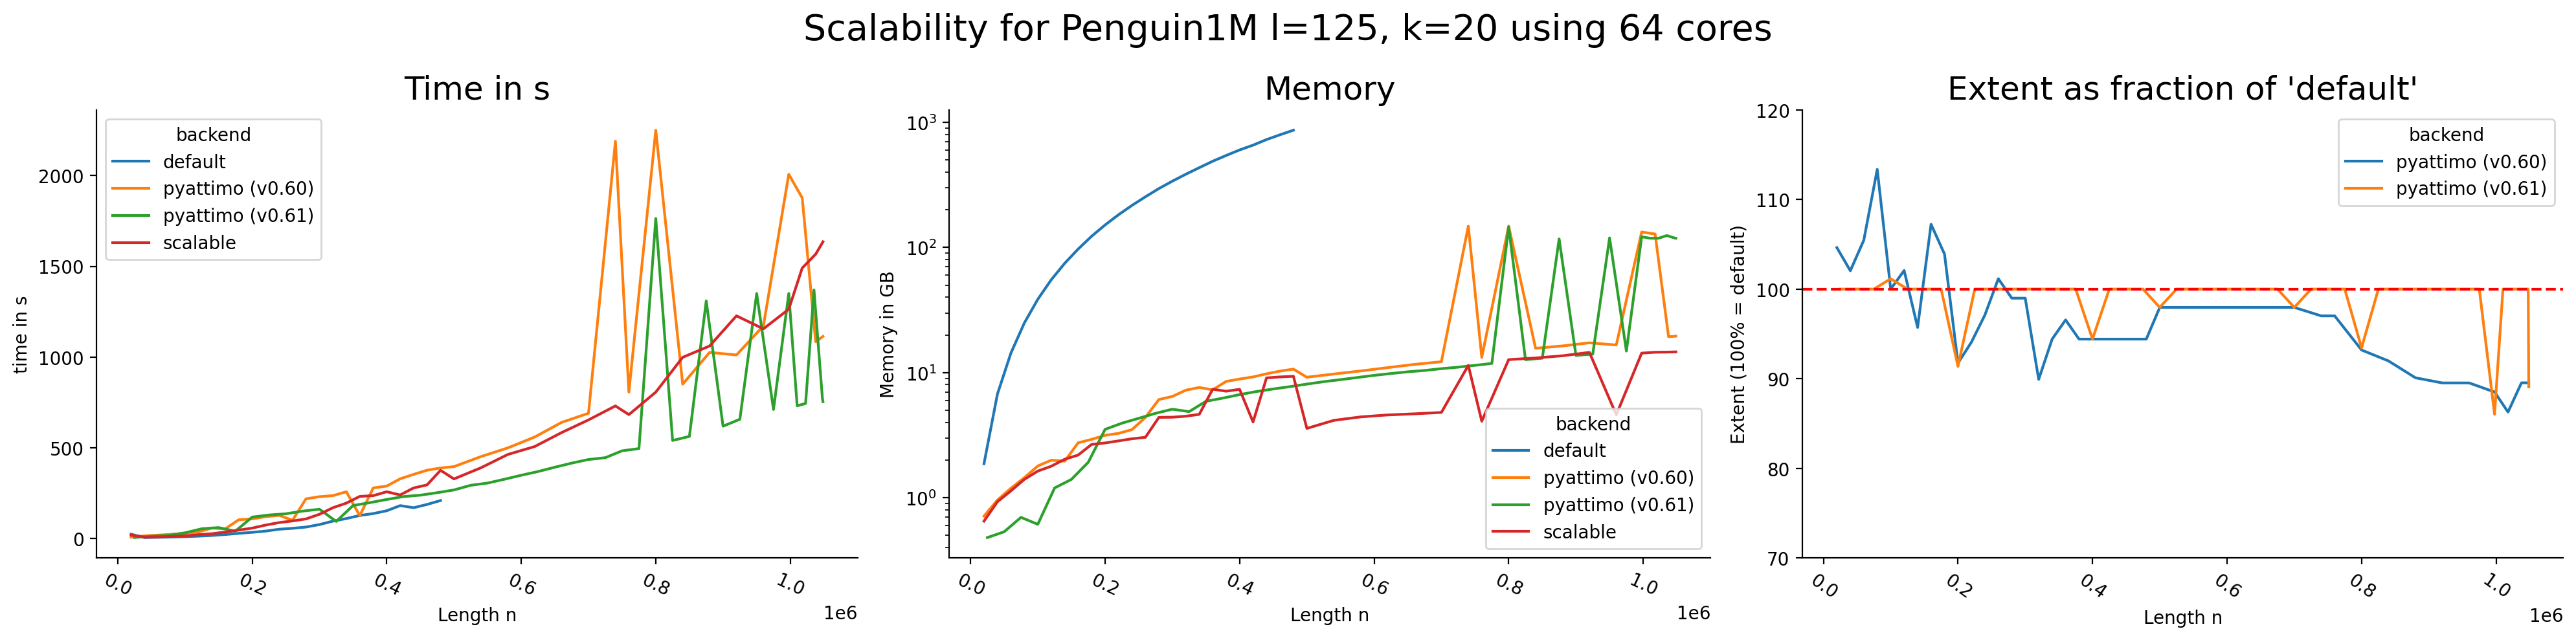

In [2]:
def read_penguin1m():
    return "Penguin1M", pd.read_csv("../tests/results/scalability_n_penguin1m_125_20.csv", index_col=0)
ds_name, df = read_penguin1m()
df = df[df.backend.isin(["default", "scalable", "pyattimo (v0.60)", "pyattimo (v0.61)"])]
plot_df(df, ds_name, l=125, k=20)

# Penguin 3m

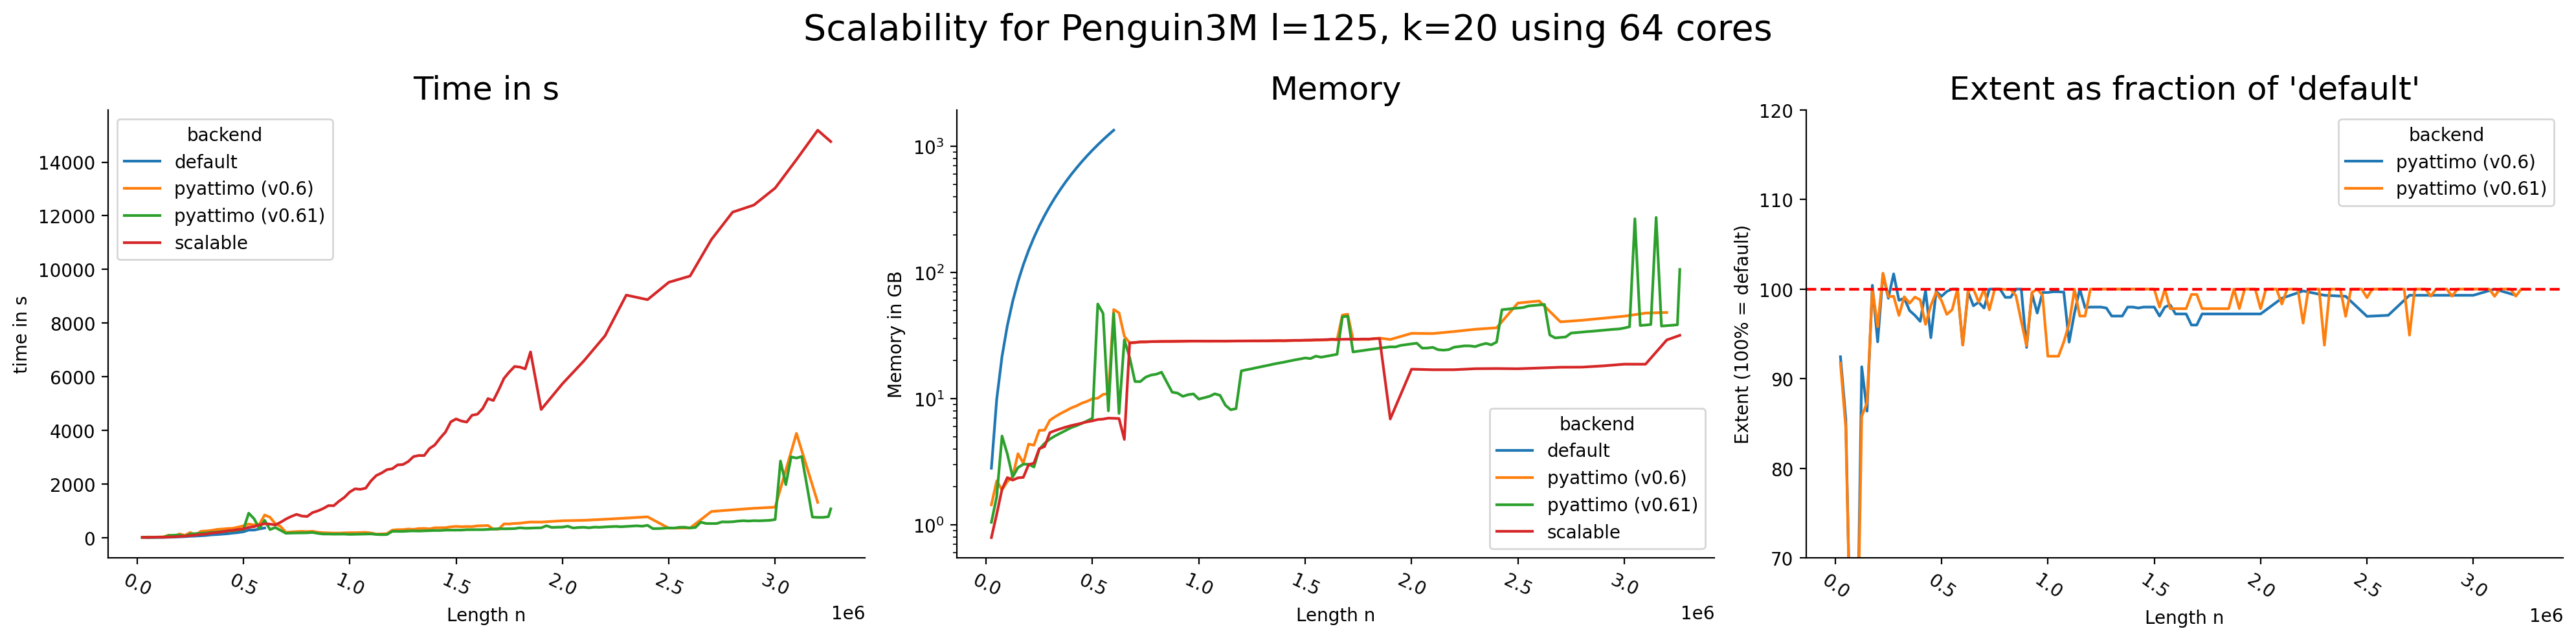

In [3]:
def read_penguin3m():
    return "Penguin3M", pd.read_csv("../tests/results/scalability_n_penguin3m_125_20.csv", index_col=0)

ds_name, df_new = read_penguin3m()
plot_df(df_new, ds_name, l=125, k=20)

# PAMAP

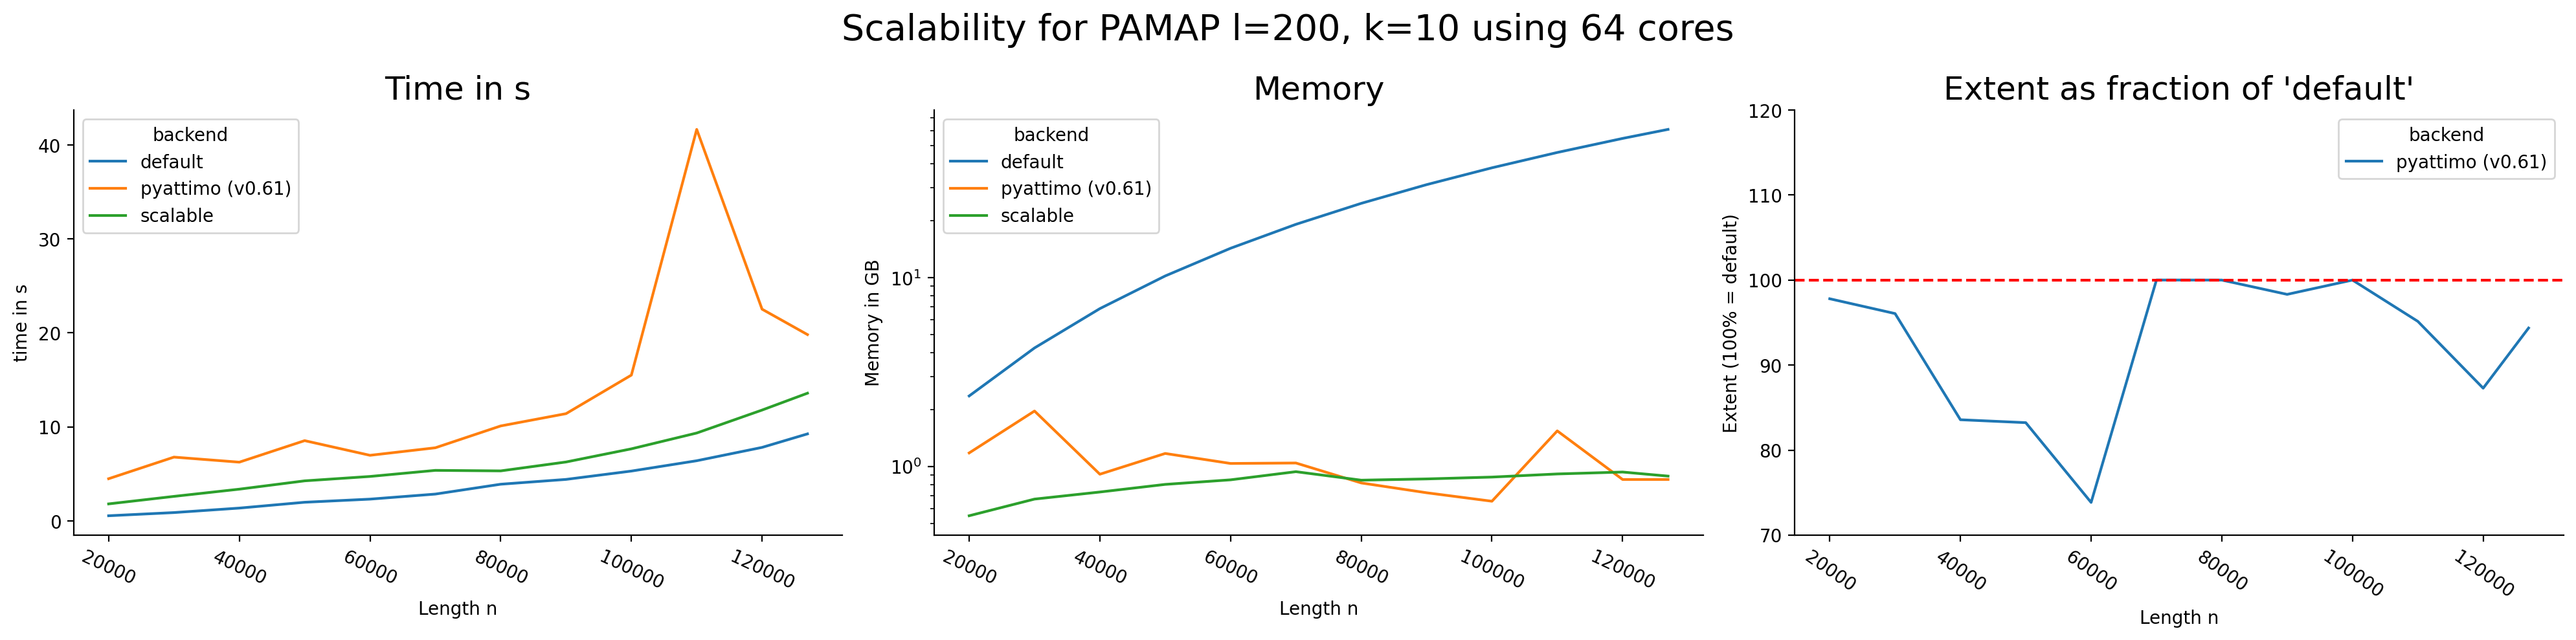

In [4]:
def read_pamap():
    return "PAMAP", pd.read_csv("../tests/results/scalability_n_PAMAP_200_10.csv", index_col=0)

ds_name, df_new = read_pamap()
plot_df(df_new, ds_name, l=200, k=10)

# Arrhythmia

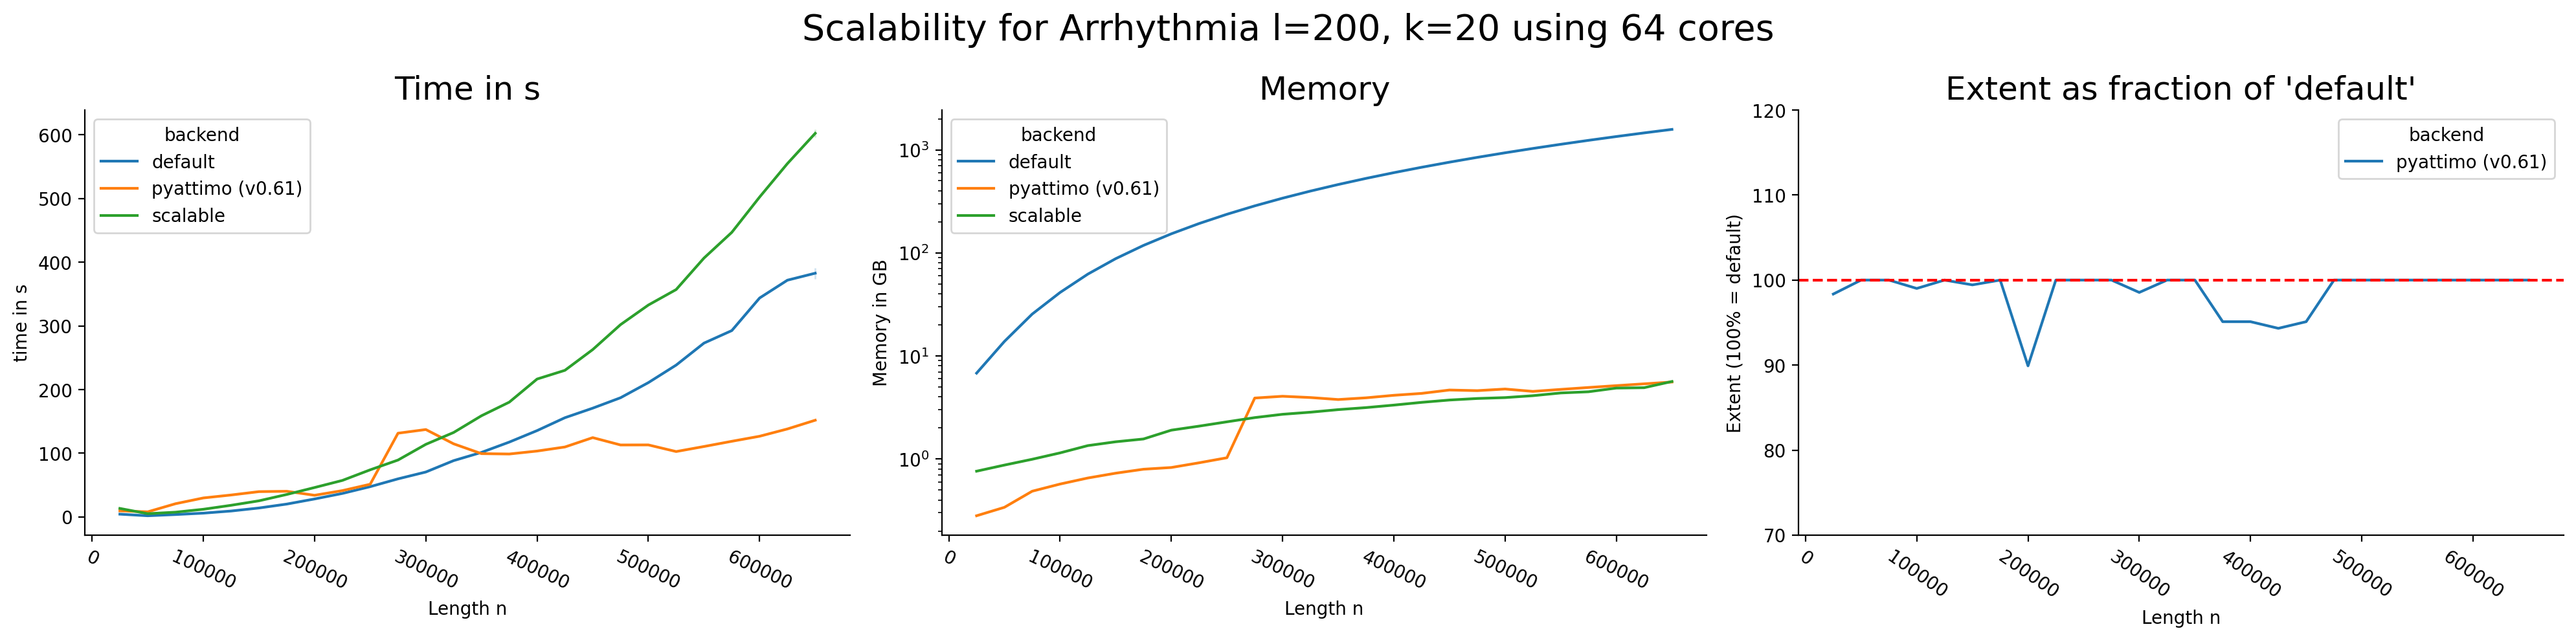

In [5]:
def read_arrhythmia():
    return "Arrhythmia", pd.read_csv("../tests/results/scalability_n_Arrhythmia_200_20.csv", index_col=0)

ds_name, df_new = read_arrhythmia()
plot_df(df_new, ds_name, l=200, k=20)

# EEG Sleep Data

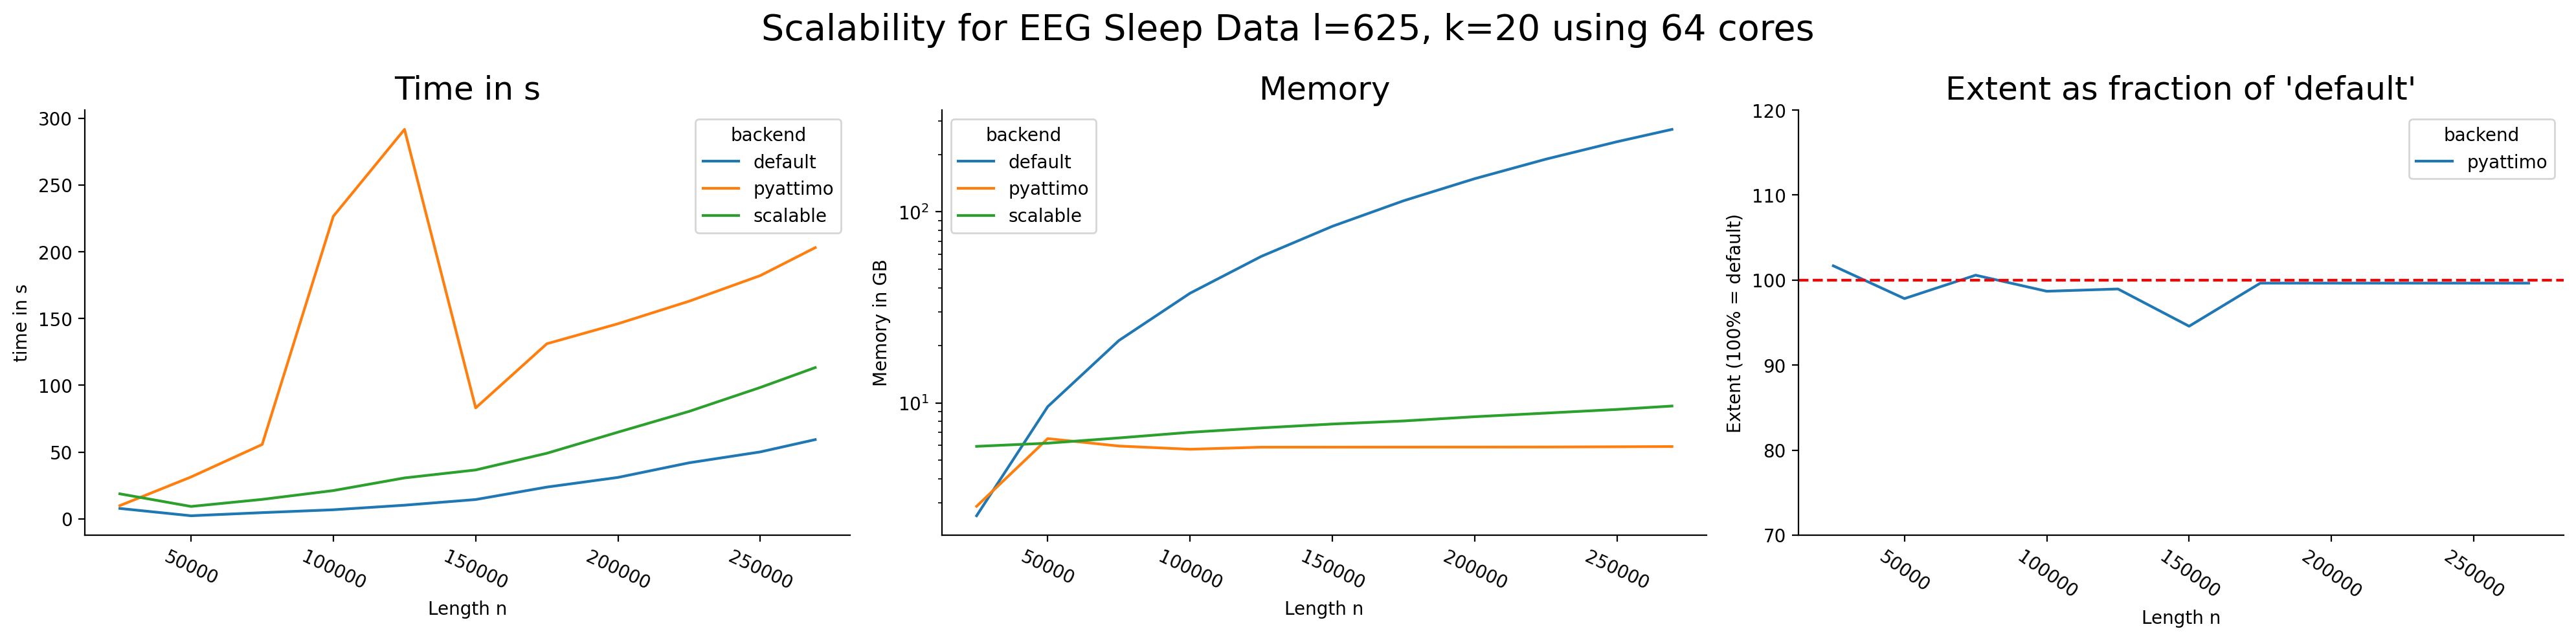

In [6]:
def read_EEG():
    return "EEG Sleep Data", pd.read_csv("../tests/results/scalability_n_EEG-Sleep_625_20.csv", index_col=0)

ds_name, df_new = read_EEG()
plot_df(df_new, ds_name, l=625, k=20)

# Dishwasher

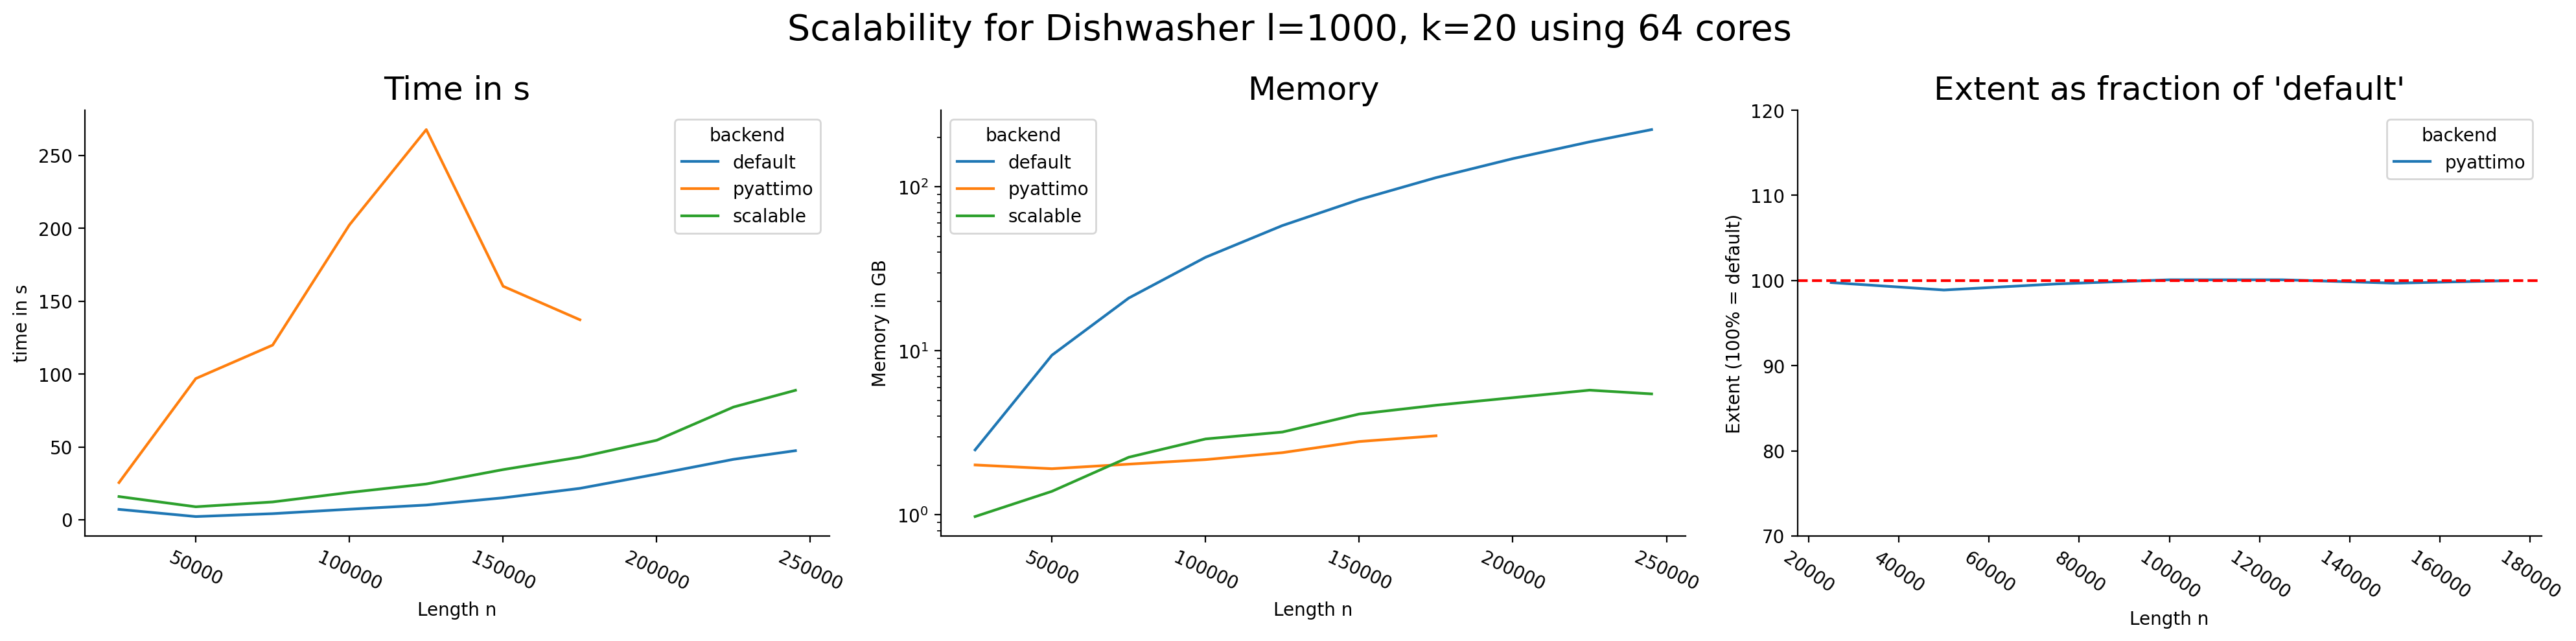

In [7]:
def read_dishwasher():
    return "Dishwasher", pd.read_csv("../tests/results/scalability_n_Dishwasher_1000_20.csv", index_col=0)

ds_name, df_new = read_dishwasher()
plot_df(df_new, ds_name, l=1000, k=20)

# GAP

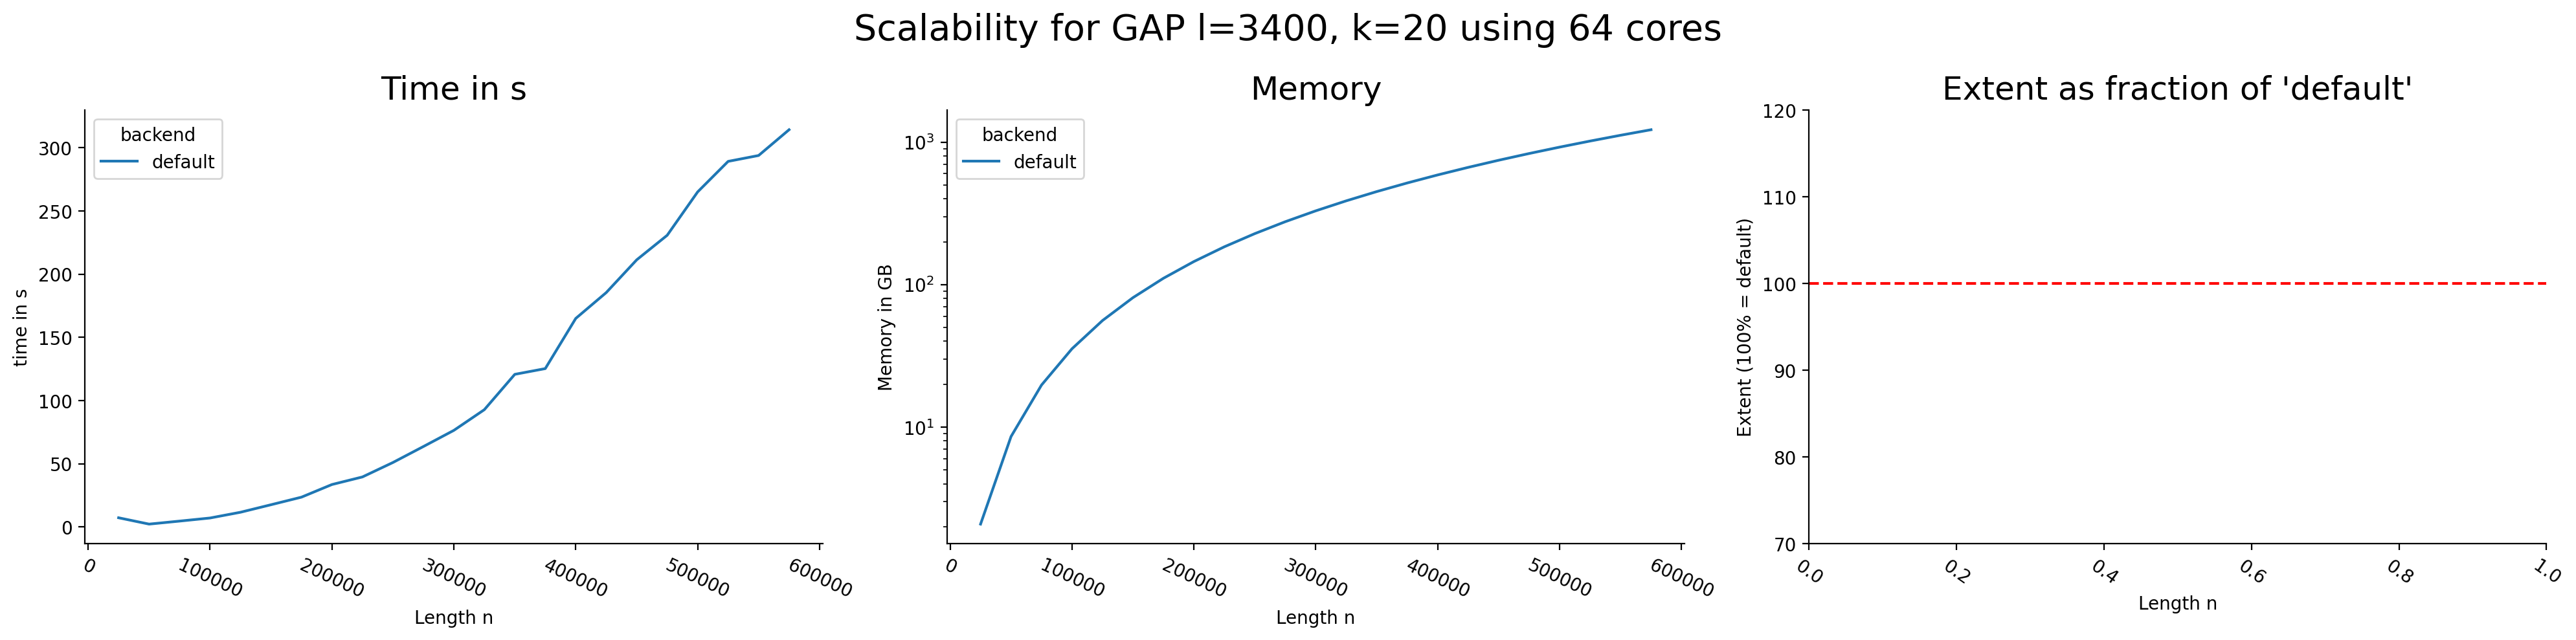

In [8]:
def read_gap():
    return "GAP", pd.read_csv("../tests/results/scalability_n_GAP_3400_20.csv", index_col=0)

ds_name, df_new = read_gap()
plot_df(df_new, ds_name, l=3400, k=20)